In [2]:
import sys
sys.path.append('/Users/tushuyang/Library/CloudStorage/OneDrive-个人/development/remote_dev/')
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

train = pd.read_csv('titanic/train.csv',index_col=0)
test = pd.read_csv('titanic/train.csv',index_col=0)

quantitative = train.select_dtypes(include=[np.number])
qualitative = train.select_dtypes(exclude=[np.number])

In [3]:
quantitative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 48.7 KB


In [4]:
quantitative.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
qualitative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      891 non-null    object
 1   Sex       891 non-null    object
 2   Ticket    891 non-null    object
 3   Cabin     204 non-null    object
 4   Embarked  889 non-null    object
dtypes: object(5)
memory usage: 41.8+ KB


/var/folders/x1/x95m9hrx431cc08rh8f3cs_c0000gp/T/ipykernel_87916/2908793604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  miss_train.sort_values(by='Age',na_position='first',inplace=True)


<AxesSubplot: >

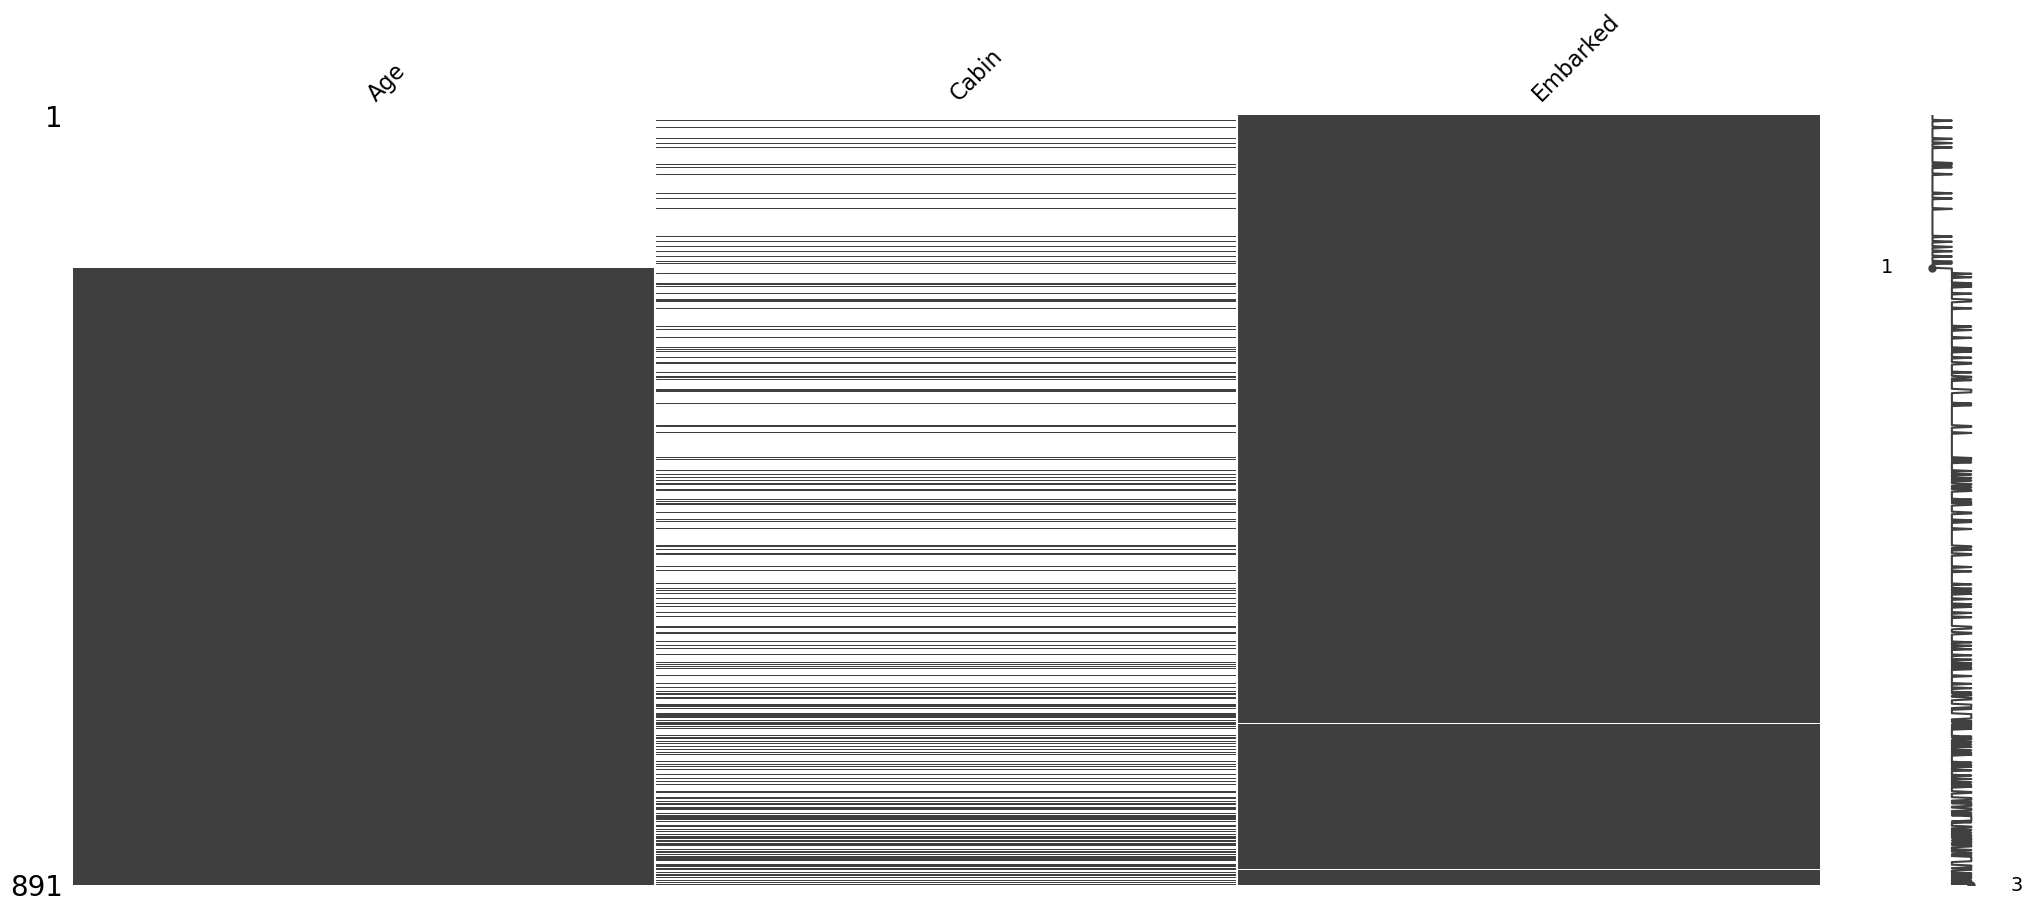

In [6]:
import missingno as msno

miss_train= train[train.columns[train.isna().sum()>0]]
miss_train.sort_values(by='Age',na_position='first',inplace=True)

msno.matrix(miss_train)

In [7]:
train[train['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [8]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
# drop the row with missing Embarked
train.dropna(subset=['Embarked'],inplace=True)

In [10]:
# drop the name column
train.drop(['Name'],axis=1,inplace=True)

In [11]:
# creat a new column for number of people with the same ticket
train['Ticket_count'] = train.groupby('Ticket')['Ticket'].transform('count')

In [12]:
# drop the ticket column
train.drop(['Ticket'],axis=1,inplace=True)

In [13]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_count
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,NaN,S,1
2,1,1,female,38.0,1,0,71.2833,C85,C,1
3,1,3,female,26.0,0,0,7.9250,NaN,S,1
4,1,1,female,35.0,1,0,53.1000,C123,S,2
5,0,3,male,35.0,0,0,8.0500,NaN,S,1


<AxesSubplot: xlabel='Pclass', ylabel='Fare'>

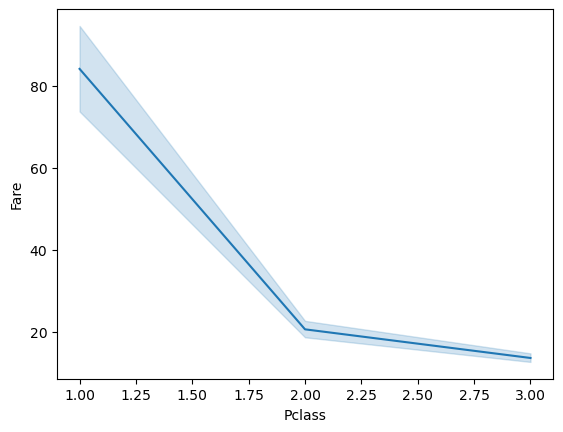

In [14]:
# plot the Pclass and Fare
sns.lineplot(x='Pclass',y='Fare',data=train)

In [15]:
# drop the Fare column
train.drop('Fare',axis=1,inplace=True)

In [16]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Ticket_count
PassengerId,,,,,,,,,
1,0,3,male,22.0,1,0,NaN,S,1
2,1,1,female,38.0,1,0,C85,C,1
3,1,3,female,26.0,0,0,NaN,S,1
4,1,1,female,35.0,1,0,C123,S,2
5,0,3,male,35.0,0,0,NaN,S,1


In [17]:
# explore the relationship between Pclass and cabin

train[train['Pclass']==1]['Cabin'].value_counts(dropna=False)

NaN                40
B96 B98             4
C23 C25 C27         4
C22 C26             3
E24                 2
C125                2
D36                 2
C93                 2
C78                 2
D35                 2
E8                  2
B77                 2
E67                 2
B20                 2
B35                 2
C123                2
B49                 2
B5                  2
C65                 2
B51 B53 B55         2
B57 B59 B63 B66     2
C126                2
C124                2
E44                 2
B18                 2
C52                 2
D33                 2
C92                 2
D20                 2
B22                 2
D26                 2
C68                 2
B58 B60             2
E25                 2
D17                 2
C2                  2
E33                 2
C83                 2
A26                 1
B50                 1
B39                 1
D48                 1
C86                 1
B41                 1
A23                 1
D9        

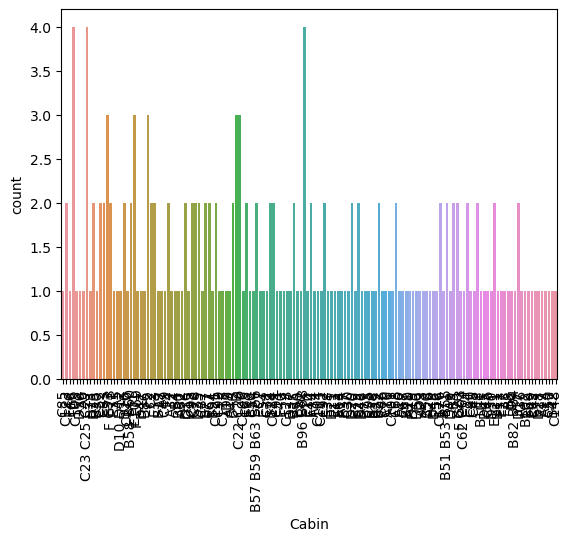

In [18]:
# plot the cabin distribution
sns.countplot(x='Cabin',data=train)
plt.xticks(rotation=90)
plt.show()

In [19]:
train[train['Cabin'].str.len()>4]


,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Ticket_count
PassengerId,,,,,,,,,
28,0,1,male,19.00,3,2,C23 C25 C27,S,4
76,0,3,male,25.00,0,0,F G73,S,1
89,1,1,female,23.00,3,2,C23 C25 C27,S,4
98,1,1,male,23.00,0,1,D10 D12,C,1
119,0,1,male,24.00,0,1,B58 B60,C,2
129,1,3,female,NaN,1,1,F E69,C,2
298,0,1,female,2.00,1,2,C22 C26,S,4
300,1,1,female,50.00,0,1,B58 B60,C,2
306,1,1,male,0.92,1,2,C22 C26,S,4


In [20]:
# find cabin list
cabin_list = []
for x in train['Cabin'].unique():
    if type(x) == str:
        cabins = x.split(' ')
        for cabin in cabins:
            cabin_list.append(cabin)
cabin_list = list(set(cabin_list))
len(cabin_list)
    

160

In [21]:
# create cabin dummy variables
for cabin in cabin_list:
    name = 'cabin_' + cabin
    train[name] = train['Cabin'].apply(lambda x: 1 if cabin in str(x) else 0)

train.head()

/var/folders/x1/x95m9hrx431cc08rh8f3cs_c0000gp/T/ipykernel_87916/3554552883.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[name] = train['Cabin'].apply(lambda x: 1 if cabin in str(x) else 0)
/var/folders/x1/x95m9hrx431cc08rh8f3cs_c0000gp/T/ipykernel_87916/3554552883.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train[name] = train['Cabin'].apply(lambda x: 1 if cabin in str(x) else 0)
/var/folders/x1/x95m9hrx431cc08rh8f3cs_c0000gp/T/ipykernel_87916/3554552883.py:4: PerformanceWarning: DataFrame is highly fragment

,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,Ticket_count,cabin_C87,...,cabin_B20,cabin_D6,cabin_D36,cabin_E77,cabin_C49,cabin_E33,cabin_C47,cabin_D7,cabin_E121,cabin_E49
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,NaN,S,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,female,38.0,1,0,C85,C,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,female,26.0,0,0,NaN,S,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,female,35.0,1,0,C123,S,2,0,...,0,0,0,0,0,0,0,0,0,0
5,0,3,male,35.0,0,0,NaN,S,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# drop the cabin column
train.drop('Cabin',axis=1,inplace=True)

In [23]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,Ticket_count,cabin_C87,cabin_B71,...,cabin_B20,cabin_D6,cabin_D36,cabin_E77,cabin_C49,cabin_E33,cabin_C47,cabin_D7,cabin_E121,cabin_E49
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,S,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,female,38.0,1,0,C,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,female,26.0,0,0,S,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,female,35.0,1,0,S,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,3,male,35.0,0,0,S,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# convert sex to numeric
train['Sex'] = train['Sex'].apply(lambda x: 1 if x=='male' else 0)

In [25]:
# covert Embarked to dummy variables
train = pd.get_dummies(train,columns=['Embarked'],drop_first=True)

In [26]:
# fill the missing age with median
train['Age'].fillna(train['Age'].median(),inplace=True)

In [27]:
# standardize the age column
train['Age'] = StandardScaler().fit_transform(train['Age'].values.reshape(-1,1))

In [28]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket_count,cabin_C87,cabin_B71,cabin_D45,...,cabin_D36,cabin_E77,cabin_C49,cabin_E33,cabin_C47,cabin_D7,cabin_E121,cabin_E49,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,1,-0.563674,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0.669217,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,3,0,-0.255451,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,1,0,0.438050,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,3,1,0.438050,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
# check missing values again
train.isna().sum()

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Ticket_count    0
cabin_C87       0
cabin_B71       0
cabin_D45       0
cabin_E69       0
cabin_A16       0
cabin_C83       0
cabin_B69       0
cabin_D21       0
cabin_D10       0
cabin_C82       0
cabin_C148      0
cabin_D26       0
cabin_B77       0
cabin_C65       0
cabin_A31       0
cabin_C52       0
cabin_D46       0
cabin_T         0
cabin_B78       0
cabin_C86       0
cabin_C45       0
cabin_E10       0
cabin_F38       0
cabin_C111      0
cabin_D28       0
cabin_D33       0
cabin_C2        0
cabin_C104      0
cabin_F33       0
cabin_C110      0
cabin_A6        0
cabin_B57       0
cabin_C27       0
cabin_E31       0
cabin_E46       0
cabin_D56       0
cabin_A14       0
cabin_B41       0
cabin_E17       0
cabin_C123      0
cabin_B53       0
cabin_D20       0
cabin_D30       0
cabin_C103      0
cabin_B37       0
cabin_D47       0
cabin_B86       0
cabin_E12       0
cabin_E44 

In [30]:
# get X and y
X_train = train.drop('Survived',axis=1)
y_train = train['Survived']

In [31]:
# try KNN model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# create KNN model
knn = KNeighborsClassifier(n_neighbors=5)

cross_vs = cross_val_score(knn,X_train,y_train,cv=5)
cross_vs

array([0.78089888, 0.76966292, 0.82022472, 0.79775281, 0.83050847])

In [32]:
# try logistic regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

cross_vs = cross_val_score(log_reg,X_train,y_train,cv=5)
cross_vs

array([0.79775281, 0.7752809 , 0.80337079, 0.76404494, 0.81355932])

In [33]:
# try random forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

cross_vs = cross_val_score(rfc,X_train,y_train,cv=5)
cross_vs

array([0.76966292, 0.7752809 , 0.83707865, 0.79775281, 0.81355932])

In [34]:
# try XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier()

cross_vs = cross_val_score(xgb,X_train,y_train,cv=5)
cross_vs

array([0.80898876, 0.80898876, 0.8258427 , 0.8258427 , 0.83050847])

In [35]:
# try SVM
from sklearn.svm import SVC

svc = SVC()

cross_vs = cross_val_score(svc,X_train,y_train,cv=5)

cross_vs

array([0.84269663, 0.82022472, 0.8258427 , 0.80898876, 0.84180791])

In [36]:
# go with XGBoost and tune the parameters
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()
params_grid = {'max_depth':[3,4,5,6,7,8,9,10]}

grid_search = GridSearchCV(xgb,params_grid,cv=5)

grid_search.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]})

In [37]:
grid_search.best_score_

0.8256459087158003

In [39]:
# go with svm and tune the parameters
from sklearn.model_selection import RandomizedSearchCV

params_dist={'C':stats.uniform(0.1,1000),
                'gamma':stats.uniform(0.1,1000),
                'kernel':['rbf','linear','poly','sigmoid']}
svc = SVC()

random_cv_search = RandomizedSearchCV(svc,params_dist,n_iter=100,n_jobs=-1,cv=5)

grid_search.fit(X_train,y_train)

In [ ]:
grid_search.best_params_

{'C': 1}